In [1]:
import GPy
# import time
import copy
import math
import matplotlib.pyplot as plt
import numpy as np
import torch


from pbp_code.PBP_net.PBP_net import PBPNet

from sgld_code.wrapper import Langevin_Wrapper

In [2]:
%load_ext autoreload

%autoreload 2

In [3]:
np.random.seed(2)

In [4]:
torch_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# colors for plotting
c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
     '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

## Dataset generation

In [6]:
x_plot = np.linspace(-5, 5, 200) # dataset to plot the uncertainities

In [7]:
def generate_rbf_dataset():
    '''
    Dataset using the RBF kernel
    '''
    no_points = 400
    lengthscale = 1
    variance = 1.0
    sig_noise = 0.3
    x = np.random.uniform(-3, 3, no_points)[:, None]


    k = GPy.kern.RBF(input_dim = 1, variance = variance, lengthscale = lengthscale)
    C = k.K(x, x) + np.eye(no_points)*sig_noise**2

    y = np.random.multivariate_normal(np.zeros((no_points)), C)[:, None]
    y = (y - y.mean())
    
    x_train = x[:250]
    y_train = y[:250]
    
    x_test = x[250:]
    y_test = y[250:]
    
    return x_train, y_train, x_test, y_test

In [8]:
def generate_cubic_dataset():
    '''
    Generate the dataset for y=x^3 with noise in y_train and y_train
    
    '''
    
    no_points = 40
    x = np.random.uniform(-4, 4, no_points)
    
    # adding noise with variance 9
    y = (x**3 + np.random.randn(x.shape[0])*3)/100
    y_plot = (x_plot**3)/100
    

    x_train = x[:30, None]
    y_train = y[:30]
    
    x_test = x[30:, None]
    y_test = y[30:]
    
    return x_train, y_train, x_test, y_test, y_plot

## SGLD

In [9]:
def estimate_uncertainity_sgld(num_hidden_layers, 
                               num_hidden_units, 
                               x_train, 
                               y_train, 
                               x_test, 
                               x_plot):
    '''
    Uncertainity estimation using SGLD
    '''
    
    # Training portion
    
    best_net, best_loss = None, float('inf')
    num_nets, nets, losses = 50, [], []
    mix_epochs, burnin_epochs = 100, 3000
#     mix_epochs, burnin_epochs = 100, 100000
    num_epochs = mix_epochs*num_nets + burnin_epochs

    num_epochs, batch_size, nb_train = 8000, len(x_train), len(x_train)
#     num_epochs, batch_size, nb_train = 500000, len(x_train), len(x_train)

    net = Langevin_Wrapper(input_dim=1, 
                           output_dim=1, 
                           no_units=num_hidden_units, 
                           learn_rate=1e-4,
                           batch_size=batch_size, 
                           no_batches=1, 
                           init_log_noise=0, 
                           weight_decay=1,
                           num_hidden_layers = num_hidden_layers
                          )

    for i in range(num_epochs):

        loss = net.fit(x_train, y_train)

        if i % 200 == 0:
            print('Epoch: %4d, Train loss = %8.3f' % (i, loss.cpu().data.numpy()))

        if i % mix_epochs == 0 and i > burnin_epochs: nets.append(copy.deepcopy(net.network))
            
    
    # inference and uncertainity estimation
    print("Using %d networks for prediction" % len(nets))
    
     # for x_plot
    samples = []
    noises = []
    for network in nets:
        preds = network.forward(torch.FloatTensor(x_plot).to(torch_device)).cpu().data.numpy()
        samples.append(preds)
        noises.append(torch.exp(network.log_noise).cpu().data.numpy())

    samples = np.array(samples)
    noises = np.array(noises).reshape(-1)
    predict_plot = (samples.mean(axis = 0)).reshape(-1)

#     aleatoric_test = noises.mean()
    epistemic_plot = (samples.var(axis = 0)**0.5).reshape(-1)
#     total_unc_test = (aleatoric**2 + epistemic**2)**0.5
    
    # for x_test
    samples = []
    noises = []
    for network in nets:
        preds = network.forward(torch.FloatTensor(x_test).to(torch_device)).cpu().data.numpy()
        samples.append(preds)
        noises.append(torch.exp(network.log_noise).cpu().data.numpy())

    samples = np.array(samples)
    noises = np.array(noises).reshape(-1)
    predict_test = (samples.mean(axis = 0)).reshape(-1)

#     aleatoric_test = noises.mean()
    epistemic_test = (samples.var(axis = 0)**0.5).reshape(-1)
#     total_unc_test = (aleatoric**2 + epistemic**2)**0.5

    net = None

    return predict_test, predict_plot, epistemic_test, epistemic_plot

## PBP code

In [10]:
def estimate_uncertainity_pbp(num_hidden_layers, 
                               num_hidden_units, 
                               x_train, 
                               y_train, 
                               x_test, 
                               x_plot):
    '''
    Uncertainity estimation using probabilistic backprop
    '''

    net = PBPNet(x_train, np.squeeze(y_train),
                 [num_hidden_units]*num_hidden_layers, normalize=True, n_epochs=40)
    
        
    predictions_test, v_test, v_noise_test = net.predict(x_test.reshape(-1, 1))
    
    predictions_plot, v_plot, v_noise_plot = net.predict(x_plot.reshape(-1, 1))
    
    return predictions_test, predictions_plot, np.sqrt(v_test), np.sqrt(v_plot)
    
        
    
    

## Run experiments

In [11]:
def run_experiment(num_hidden_layers, num_hidden_units, x_train, y_train, x_test, x_plot, y_plot):
    '''
    Run the experiments on SGLD and PBP algorithms
    
    Plots the predictions with the associated uncertainities
    '''
    
    # run the experiments
    _, predict_plot_sgld, _, std_plot_sgld = estimate_uncertainity_sgld(
        num_hidden_layers,
        num_hidden_units,
        x_train,
        y_train,
        x_test, 
        x_plot
    )
    
    _, predict_plot_pbp, _, std_plot_pbp = estimate_uncertainity_pbp(
        num_hidden_layers,
        num_hidden_units,
        x_train,
        y_train,
        x_test, 
        x_plot
    )
    
    
    
    plt.figure()
    plt.scatter(x_train, y_train, s = 10, marker = 'x', color = 'black', alpha = 0.5, label='training data')
    plt.fill_between(
        x_plot, 
        predict_plot_pbp - 3*std_plot_pbp, 
        predict_plot_pbp + 3*std_plot_pbp, 
        color = c[0], 
        alpha = 0.3, 
        label='PBP uncertainity'
    )
    plt.plot(x_plot, predict_plot_pbp, color = c[0], alpha=0.8, label='PBP prediction')
    
    plt.fill_between(
        x_plot, 
        predict_plot_sgld - 3*std_plot_sgld, 
        predict_plot_sgld + 3*std_plot_sgld, 
        color = c[1], 
        alpha = 0.3, 
        label='SGLD uncertainity'
    )
    plt.plot(x_plot, predict_plot_sgld, color = c[1], alpha=0.8, label='SGLD prediction')
    
    plt.plot(x_plot, y_plot, color = c[2], alpha=0.8, label='Ground Truth')
    
    plt.xlabel('x')
    plt.title('Prediction and uncertainity')
    plt.gca().yaxis.grid(alpha=0.3)
    plt.gca().xaxis.grid(alpha=0.3)
    
    plt.legend()
    
    plt.show()

### Cubic dataset with a single hidden layer

In [12]:
# generate cubic dataset

x_train, y_train, x_test, y_test, y_plot = generate_cubic_dataset()

Epoch:    0, Train loss =   17.604
Epoch:  200, Train loss = -992.698
Epoch:  400, Train loss = -1062.951
Epoch:  600, Train loss = -902.924
Epoch:  800, Train loss = -250.978
Epoch: 1000, Train loss = -852.237
Epoch: 1200, Train loss = -1041.756
Epoch: 1400, Train loss = -1031.850
Epoch: 1600, Train loss = -1049.824
Epoch: 1800, Train loss = -1046.783
Epoch: 2000, Train loss =  421.257
Epoch: 2200, Train loss = -1093.247
Epoch: 2400, Train loss = -1095.500
Epoch: 2600, Train loss = -626.543
Epoch: 2800, Train loss = -1079.995
Epoch: 3000, Train loss = -1031.719
Epoch: 3200, Train loss = -1042.705
Epoch: 3400, Train loss =  420.310
Epoch: 3600, Train loss = -1078.190
Epoch: 3800, Train loss = -898.476
Epoch: 4000, Train loss = -956.861
Epoch: 4200, Train loss = -1085.453
Epoch: 4400, Train loss = -1054.739
Epoch: 4600, Train loss = -1087.340
Epoch: 4800, Train loss = -1061.718
Epoch: 5000, Train loss = -1041.516
Epoch: 5200, Train loss = -1061.387
Epoch: 5400, Train loss = -1033.178
Ep

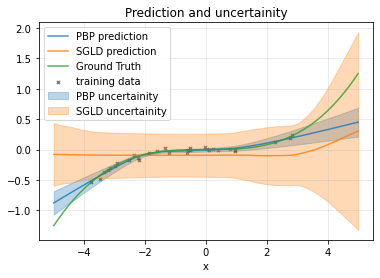

In [13]:
run_experiment(1, 50, x_train, y_train, x_test, x_plot, y_plot)

### RBF data with 2 layers

In [14]:
# generate cubic dataset

x_train, y_train, x_test, y_test = generate_rbf_dataset()
y_plot = np.zeros(x_plot.shape[0])

In [16]:
run_experiment(3, 200, x_train, y_train, x_test, x_plot, y_plot)

Epoch:    0, Train loss =  104.713
Epoch:  200, Train loss =  -90.413
Epoch:  400, Train loss =  -26.615
Epoch:  600, Train loss =  327.747
Epoch:  800, Train loss =  105.203
Epoch: 1000, Train loss =  537.933
Epoch: 1200, Train loss =  -36.052
Epoch: 1400, Train loss =  125.270
Epoch: 1600, Train loss =   64.463
Epoch: 1800, Train loss =   -9.794
Epoch: 2000, Train loss =  140.379
Epoch: 2200, Train loss =  369.335
Epoch: 2400, Train loss =    4.711
Epoch: 2600, Train loss = 4869.514
Epoch: 2800, Train loss = 3619.531
Epoch: 3000, Train loss = 2370.216
Epoch: 3200, Train loss = 1533.150
Epoch: 3400, Train loss =  793.151
Epoch: 3600, Train loss =  646.356
Epoch: 3800, Train loss =  590.467
Epoch: 4000, Train loss =  732.839
Epoch: 4200, Train loss =  846.806
Epoch: 4400, Train loss = 1378.919
Epoch: 4600, Train loss =  545.850
Epoch: 4800, Train loss =  335.995
Epoch: 5000, Train loss =  476.998
Epoch: 5200, Train loss =   63.764
Epoch: 5400, Train loss =      nan
Epoch: 5600, Train l

KeyboardInterrupt: 